# Chapter 4: Data Analysis

In this chapter we discuss basic issues in analysing the extracted AFL data, and provide
some initial exploratory data analyses, including the fitting of various probability distributions
to the data.

## Training and testing data

As previously discussed in
[Chapter 1](1_introduction.ipynb#Model-validation "Introduction: Model validation"),
for the purposes of data analysis and modelling we should partition the data into *training* and 
*testing* sets. Only the training data should be subject to exploratory data analysis, and the testing data should be kept only for model validation. Actually, to be completely fair, there should also be an additional *validation* data-set. Multiple models should be validated against this data-set, and only the selected, best model should be tested on the testing data.

However, in a 'live' system, the *retrospective* analysis of model building would be coupled with *prospective* prediction of future matches, so these yet-to-be-collected matches would act as ongoing testing data. Monitoring of predictive performance and data distributions over time would then also
allow testing for other issues such as 
[*concept drift*](https://en.wikipedia.org/wiki/Concept_drift "Wikipedia"),
where the model no longer accurately reflects the data.

Recall from [Chapter 3](3_feature_extraction.ipynb "Chapter 3: Feature Extraction")
that historical features were extracted for every collected AFL match. Consequently, we are permitted to treat each match, coupled with its corresponding features, as being 
[independent](1_introduction.ipynb#Causality-and-independence-of-observations
"Introduction: Causality and independence of observations").
For simplicity, we arbitrarily take all matches from 1990 to 2020 as the training data, and matches from 2021 onwards as testing/validation data. 

A better scheme might have been to randomly partition the matches per season, or even completely at random per match. However, this would make it harder to test for temporal representativeness (a form of concept drift discussed in a
[later](#Temporal-representativeness "Section: Temporal representativeness") section).
In addition, we would typically apply a partitioning rule such as 90/10 or 80/20, to control
the proportion of training data to testing data. 

### Load the data

In [1]:
import sys
import os

sys.path.append(os.path.join("..", "python"))

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
df_matches = pd.read_csv(os.path.join("..", "data", "matches.csv"))

In [5]:
df_matches

,season,round,datetime,venue,for_team,for_is_home,for_goals1,for_behinds1,for_goals2,for_behinds2,...,against_goals3,against_behinds3,against_goals4,against_behinds4,against_total_score,against_match_points,against_is_win,against_is_draw,against_is_loss,edge_type
0,1990,R1,Sat 31-Mar-1990 2:10 PM,Princes Park,Carlton,True,6,5,4,4,...,6,3,6,5,104,4,True,False,False,lost-to
1,1990,R1,Sat 31-Mar-1990 2:10 PM,M.C.G.,Melbourne,False,6,2,4,1,...,4,4,3,4,89,0,False,False,True,defeated
2,1990,R1,Sat 31-Mar-1990 2:10 PM,Waverley Park,Geelong,True,5,3,2,3,...,9,7,10,6,192,4,True,False,False,lost-to
3,1990,R1,Sat 31-Mar-1990 2:10 PM,Windy Hill,Essendon,True,7,4,6,7,...,1,3,2,4,60,0,False,False,True,defeated
4,1990,R1,Sat 31-Mar-1990 7:40 PM,Carrara,Brisbane Bears,True,4,3,3,2,...,1,3,3,2,74,0,False,False,True,defeated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6489,2024,R7,Sat 20-Apr-2024 4:35 PM,Docklands,Carlton,True,5,1,2,6,...,3,3,3,1,98,0,False,False,True,defeated
6490,2024,R7,Sat 20-Apr-2024 6:10 PM,Perth Stadium,Fremantle,False,0,3,3,0,...,5,5,2,0,105,4,True,False,False,lost-to
6491,2024,R7,Sat 20-Apr-2024 7:30 PM,Gabba,Brisbane Lions,True,2,5,1,3,...,2,2,3,3,63,4,True,False,False,lost-to
6492,2024,R7,Sun 21-Apr-2024 1:05 PM,S.C.G.,Gold Coast,False,1,2,2,3,...,7,4,5,0,110,4,True,False,False,lost-to


In [6]:
print(df_matches.columns)

Index(['season', 'round', 'datetime', 'venue', 'for_team', 'for_is_home',
       'for_goals1', 'for_behinds1', 'for_goals2', 'for_behinds2',
       'for_goals3', 'for_behinds3', 'for_goals4', 'for_behinds4',
       'for_total_score', 'for_match_points', 'for_is_win', 'for_is_draw',
       'for_is_loss', 'against_team', 'against_is_home', 'against_goals1',
       'against_behinds1', 'against_goals2', 'against_behinds2',
       'against_goals3', 'against_behinds3', 'against_goals4',
       'against_behinds4', 'against_total_score', 'against_match_points',
       'against_is_win', 'against_is_draw', 'against_is_loss', 'edge_type'],
      dtype='object')


### Partition the data

In [7]:
all_seasons = df_matches.season.unique()

In [8]:
split_season = 2020
trn_seasons = all_seasons[all_seasons <= split_season]
tst_seasons = all_seasons[all_seasons > split_season]

In [9]:
df_training = df_matches[df_matches.season.isin(trn_seasons)].copy()

In [10]:
df_training.iloc[[0, -1]]

,season,round,datetime,venue,for_team,for_is_home,for_goals1,for_behinds1,for_goals2,for_behinds2,...,against_goals3,against_behinds3,against_goals4,against_behinds4,against_total_score,against_match_points,against_is_win,against_is_draw,against_is_loss,edge_type
0,1990,R1,Sat 31-Mar-1990 2:10 PM,Princes Park,Carlton,True,6,5,4,4,...,6,3,6,5,104,4,True,False,False,lost-to
5809,2020,GF,Sat 24-Oct-2020 6:30 PM,Gabba,Geelong,False,2,2,3,3,...,4,2,5,5,81,4,True,False,False,lost-to


In [11]:
df_testing = df_matches[df_matches.season.isin(tst_seasons)].copy()

In [12]:
df_testing.iloc[[0, -1]]

,season,round,datetime,venue,for_team,for_is_home,for_goals1,for_behinds1,for_goals2,for_behinds2,...,against_goals3,against_behinds3,against_goals4,against_behinds4,against_total_score,against_match_points,against_is_win,against_is_draw,against_is_loss,edge_type
5810,2021,R1,Thu 18-Mar-2021 7:25 PM,M.C.G.,Carlton,False,3,2,3,4,...,2,3,5,7,105,4,True,False,False,lost-to
6493,2024,R7,Sun 21-Apr-2024 4:05 PM,Docklands,Hawthorn,False,3,3,8,3,...,3,1,2,2,68,0,False,False,True,defeated


In [13]:
print("%d training samples" % len(df_training))
print("%d testing samples" % len(df_testing))
p = len(df_training) / len(df_matches)
print("Ratio:", 100 * p, ":", 100 * (1 - p))

5810 training samples
684 testing samples
Ratio: 89.46720049276256 : 10.532799507237446


### Save the partitioned data

In [14]:
 df_training.to_csv(os.path.join("..", "data", "training_matches.csv"), index=False)

In [15]:
df_testing.to_csv(os.path.join("..", "data", "testing_matches.csv"), index=False)

Note that, strict speaking, we should also partition the extracted features in the same fashion, in order to
obviate the possibility of contaminating our data anlyses with testing data.
In practice, we shall permit the loading of all historical data, on the assumption that queries will
only be made for matches in the training data-set.

## Null hypothesis

A typical assumption of probabilistic modelling is that every data point is independently drawn from the same underlying distribution. This is just a form of the *null* hypothesis, corresponding to the *business as usual* (BAU) rule that nothing much changes.
Informally, this means that each team is much like every other team, each match is like other matches, and each season is like other seasons.
More formally, we notionally assume the existence of a single, joint distribution from which all teams and matches are sampled.

In reality, the null hypothesis cannot strictly hold true always and everywhere. If it did, then the characteristics of each team would be stochastically sampled before a match, the results of each match would also be sampled, and consequently there would be little value in collecting historical data.
However, in practice it is apparent that some teams are stronger than others, and that this relative strength has some temporal persistence (even if only for one or more seasons). 

The benefit of considering the null hypothesis lies in aggregration. Considered over a period of time (say, a season), some teams are weak, some are strong, and some are inbetween. Thus, the teams might be thought of as being sampled from some common distribution, and it makes sense to consider the characteristics of an 'average' team. Put another way, if we consider past matches between team A and all other opponents, then team A will have faced both stronger teams and weaker teams in aggregate.
The null hypothesis is then to assume that  all such team differences cancel out on average. Consequently, we may model the outcomes of these matches as measuring the relative performance of team A against the hypothetical 'average' team. This is just the so-called *one-team* model
discussed in [Chapter 1](1_introduction.ipynb#Marginal-models "Introduction: Marginal models").

For the purposes of modelling, it is of interest to know when the null hypothesis fails. For example, if any one team is no longer just like another, then it is useful to capture these differences so
that we may more precisely predict the outcome of a match between team A and team B using
a [*two-team*](1_introduction.ipynb#Marginal-models "Introduction: Marginal models")
model.

If the null hypothesis does not hold across time, then we call this a failure of
[*temporal representativeness*](#Temporal-representativeness "Section: Temporal representativeness").
However, note that the null hypothesis might hold on one time-scale but fail to hold on a different time-scale. 
For example, if the null hypothesis were to happen to fail across multiple seasons, 
then perhaps it might still hold within a season. For instance, the relative strengths of teams might have (notionally) been sampled at the start of a season, and then held fixed for the duration of that season.

Similarly, if the null hypothesis does not hold due to environmental factors or physical constraints, then we call this a failure of 
[*physical representativeness*](#Physical-representativeness "Section: Physical representativeness").
For example, teams from different cities or suburbs might potentially show a disparity in performance due to differences in socio-economic status (e.g. due to the availability, or lack thereof, of sufficient funds to  contract top players, or build new training facilities, etc.). Likewise, we might expect most teams to play better
in dry conditions than rainy conditions, but some teams might be less affected by slippery conditions than others.

## Emprical distributions

In the following sections, we assume *a priori* that the 
[null hypothesis](#Null-hypothesis "Section: Null hypothesis") holds true, unless we find
sufficient evidence to the contrary.
Under this assumption, we aggregate all matches and examine the empirical distributions derived from the aggregated match results.
At the coarsest level, aggregation is performed across all seasons, i.e. all matches are treated alike. At a finer level, aggregation of scores may be performed temporally over a match, or 
over each half of a match, or over each quarter.

### Likelihood of a draw

At the end of an Australian Rules football match, the scores of the two opposing teams might be tied, resulting in a draw. However, as discussed in [Chapter 1](1_introduction.ipynb#The-effect-of-draws
"Introduction: The effect of draws"), draws by their nature must be statisticaly unlikely events.
Consequently, it makes sense to aggregate all matches to help overcome the scarcity of draws.

In [16]:
df_training.edge_type.unique()

array(['lost-to', 'defeated', 'drew-with'], dtype=object)

In [17]:
df_training['is_draw'] = is_draw = df_training.edge_type == 'drew-with'
p_draw = np.mean(is_draw)
num_matches = len(df_training)
#std_err = np.sqrt(np.var(is_draw) / num_matches)
std_err = np.sqrt(p_draw * (1 - p_draw) / num_matches)
print(f"Draws: matches={num_matches}, draws={sum(is_draw)}, mean={p_draw}, std. err.={std_err}")

Draws: matches=5810, draws=50, mean=0.008605851979345954, std. err.=0.0012118030613057298


We observe that the empirical probability of a draw is around 1% or less,
maing it a rare event.

### Distribution of goals

The number of goals scored by a given team in a given match is a non-negative integer.
Consequently, one might postulate *a priori* that the number of goals (in a given period of time) might follow a Poisson distribution, assuming that the rate of goal scoring remains
constant. Alternatively, one might consider the physical limitations that could restrict the maximum number of goals that may be scored in a given period of time, e.g. the size of the oval, human muscle strength, et cetera. Thus, if we were to consider a minimum time quantum in which at most one goal could be scored, then we might consider a binomial distribution.

However, there are several complications for either choice. In practice, the effective length of each quarter of a match may vary due to variations in timing due
to stoppages, e.g. when the ball goes out of play, or when there are player injuries.
Nominally, the current length of each quarter is about 20 minutes.
However, it must be noted that prior to 1994, the alotted time for AFL matches was actually 25 minutes per quarter. Also, due to the outbreak of Covid in 2020, the time was reduced for that season to only 16 minutes per quarter. For convenience, we shall neglect these problematic seasons and apply
the [null hypothesis](#Null-hypothesis "Section: Null hypothesis") that all quarters are essentially the same in length.

A second difficulty is that of *over-dispersion*, where the empirical variance is higher than
the theoretical variance of a given distribution. If this effect is significant, then
over-dispersion would need to be modelled via an alternative distribution with additional parameters.

Yet another complication arises from lack of temporal independence. For example, under the aforementioned
null hypothesis, we may aggregate all quarterly scores into a single quarterly distribution.
However, as we shall see below, the distribution of goals scored in a match has a higher variance
than would be expected from four independent draws from the quarterly distribution.
This is especially interesting since it might be expected that
accumulating the quarterly scores over each match would perhaps 'average out' inter-quarter variation.
Instead, it leads to higher variation due to non-independence of the number of goals scored
in each quarter.

Let us begin by examining the goals scored in each individual quarter of each match.

In [18]:
# Keep only matches with 20 minute quarters
ind = (df_training.season >= 1994) & (df_training.season != 2020)
columns  = ['for_goals' + str(i) for i in range(1, 5)]
for_scores = df_training.loc[ind, columns].values
columns  = ['against_goals' + str(i) for i in range(1, 5)]
against_scores = df_training.loc[ind, columns].values
goals_by_quarter = np.vstack([for_scores, for_scores])

In [19]:
print("Goal means per quarter:", np.mean(goals_by_quarter, axis=0))
print("Overall goal mean:", np.mean(goals_by_quarter))
print("Goal variances per quarter:", np.var(goals_by_quarter, axis=0))
print("Overall goal variance:", np.var(goals_by_quarter))
ps = np.sum(goals_by_quarter, axis=0) / np.sum(goals_by_quarter)
print("Proportions of all goals:", ps)

Goal means per quarter: [3.24388287 3.28760529 3.37745688 3.39229844]
Overall goal mean: 3.325310870437224
Goal variances per quarter: [3.34605664 3.53380947 3.68183437 3.80959973]
Overall goal variance: 3.596639744915929
Proportions of all goals: [0.24387817 0.24716526 0.25392039 0.25503619]


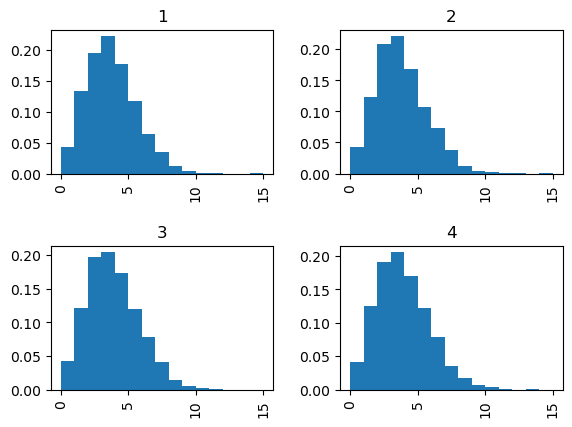

In [20]:
df_goals = pd.DataFrame(
    columns = ("quarter", "goals"),
    data = [
        x for row in goals_by_quarter 
        for x in enumerate(row, start=1)
    ]
)

max_goals = int(np.max(goals_by_quarter))
bins = list(range(max_goals + 1))
res = df_goals.hist('goals', by='quarter', bins=bins, density=True)

It would appear that statistically there are slight differences between the goal distributions from each quarter, e.g. the mean number goal of goals increases slightly from the first half (quarters 1 and 2) to the second half (quarters 3 and 4) of each match, as does the variance.
If we were to utilise a regression model of the number of goals per quarter, then we could potentially allow for variations in each quarter.

However, to a good approximation, the per-quarter goal scores appear to be identically distributed. Hence, we support the null hypothesis that any given
quarter is like any other.
Now, since the mean and variance are approximately equal, we may consider fitting a 
[Poisson](./C_regression_models.ipynb#Poisson-distribution
"Appendix C: Poisson distribution") 

In [21]:
from distributions.poisson import PoissonDistribution

In [22]:
all_goals = df_goals.goals.values

psd = PoissonDistribution()
psd.fit(all_goals)

{'score': -2.023100422395597,
 'num_iters': 2,
 'score_tol': 0.0,
 'param_tol': 4.440892098500626e-16,
 'converged': True}

In [23]:
lam = psd.get_parameters()[0]
print(f"lambda={lam}")
mu = psd.mean()
sigsq = psd.variance()
print(f"mean={mu}, variance={sigsq}")

lambda=3.325310870437224
mean=3.325310870437224, variance=3.325310870437224


Observe that the Poisson distribution slightly under-estimates the empirical variance. 
Consequently, we might try the 
[negative binomial](./C_regression_models.ipynb#Negative-binomial-distribution
"Appendix C: Negative binomial distribution")
distribution, which 
[modifies](./D_distributions.ipynb#Gamma-Poisson-distribution
"Appendix D: Gamma-Poisson distribution")
the Poisson distribution to allow for over-dispersion.

In [24]:
from distributions.neg_binomial import NegBinomialDistribution

In [25]:
nbd = NegBinomialDistribution()
nbd.fit(all_goals)

{'score': -2.021510723885497,
 'num_iters': 375,
 'score_tol': -1.7763568394002505e-15,
 'param_tol': 9.882378222414445e-07,
 'converged': True}

In [26]:
qm = np.mean(all_goals)
qv = np.var(all_goals)
print(f"Method of moments: p={qm / qv}, q={(qv - qm) / qv}, alpha={qm**2 / (qv - qm)}")

theta, alpha = nbd.get_parameters()
beta = theta / (1 - theta)
print(f"Max. likelihood: p={theta}, q={1-theta}, alpha={alpha}")
mu = nbd.mean()
sigsq = nbd.variance()
print(f"neg. binom: mean={mu}, variance={sigsq}")
print(f"gamma: beta={beta}, mu={alpha/beta}, var={alpha/beta**2}")

Method of moments: p=0.9245604526107334, q=0.07543954738926661, alpha=40.75383575114421
Max. likelihood: p=0.9235153903421085, q=0.0764846096578915, alpha=40.15155179920352
neg. binom: mean=3.3253108704372267, variance=3.6007097501703718
gamma: beta=12.074525770255041, mu=3.3253108704372267, var=0.27539887973314486


Observe that, as anticipated, the negative binomial fits the empirical variance better than the Poisson.

Next, we recall that each quarter is (in theory) 20 minutes long. We also note,
from the results above, that the maximum number of goals observed per quarter is 15.
Consequently, we might expect no more than one goal to be scored per minute of play.
Thus, we might try fitting a binomial distribution over each of the 20 minutes of each quarter.

In [27]:
from distributions.binomial import BinomialDistribution

In [28]:
bnd = BinomialDistribution(20)
bnd.fit(all_goals)

{'score': -2.0407147685153344,
 'num_iters': 1,
 'score_tol': 0.0,
 'param_tol': 8.326672684688674e-17,
 'converged': True}

In [29]:
n, theta = bnd.get_parameters()
print(f"p={theta}, q={1-theta}, n={n}")
mu = bnd.mean()
sigsq = bnd.variance()
print(f"mean={mu}, variance={sigsq}")

p=0.1662655435218613, q=0.8337344564781387, n=20.0
mean=3.325310870437226, variance=2.772426251184827


Observe that the binomial distribution, by its very nature, has
variance $\sigma^2_X=npq<\mu_X=np$. Hence, it is always under-dispersed 
in comparison to the Poisson distribution, for which 
$\sigma^2_X=\mu_X=\lambda$.
To allow for over-dispersion, we might try the 
[beta-binomial](./D_distributions.ipynb#Beta-Binomial-distribution
"Appendix D: Beta-Binomial distribution") distribution.

In [30]:
from distributions.beta_binomial import BetaBinomialDistribution

In [31]:
bbd = BetaBinomialDistribution(20)
bbd.fit(all_goals)

{'score': -2.021408525483791,
 'num_iters': 100,
 'score_tol': 6.616929226765933e-14,
 'param_tol': 4.0892373647238855e-05,
 'converged': False}

In [36]:
n, alpha, beta = bbd.get_parameters()
print(f"n={n}, alpha={alpha}, beta={beta}")
mu = bbd.mean()
sigsq = bbd.variance()
print(f"Beta-binomial: mean={mu}, variance={sigsq}")
theta = alpha / (alpha + beta)
mu = theta
sigsq = mu * (1 - mu) / (alpha + beta + 1)
print(f"Beta: mean={mu}, variance={sigsq}")
mu = n * theta
sigsq = mu * (1 - theta)
print(f"Binomial: prob={theta}, mean={mu}, variance={sigsq}")

n=20.0, alpha=10.505313789339887, beta=52.677994888972584
Beta-binomial: mean=3.3253446231586197, variance=3.593168806848246
Beta: mean=0.166267231157931, variance=0.002159789544284535
Binomial: prob=0.166267231157931, mean=3.3253446231586197, variance=2.7724487800201225


Observe that the binomial part of the beta-binomial distribution behaves as the standard binomial distribution above. However, the use of a beta distribution prior allows the over-dispersion to be modelled quite well.

In [37]:
# Observed values are integer:
#x_values = np.arange(np.max(all_goals) + 1)
# But use real values for visual smoothness:
x_values = np.linspace(min(all_goals), max(all_goals), 100)

y_values_psd = np.exp(psd.log_prob(x_values))
y_values_nbd = np.exp(nbd.log_prob(x_values))
y_values_bnd = np.exp(bnd.log_prob(x_values))
y_values_bbd = np.exp(bbd.log_prob(x_values))

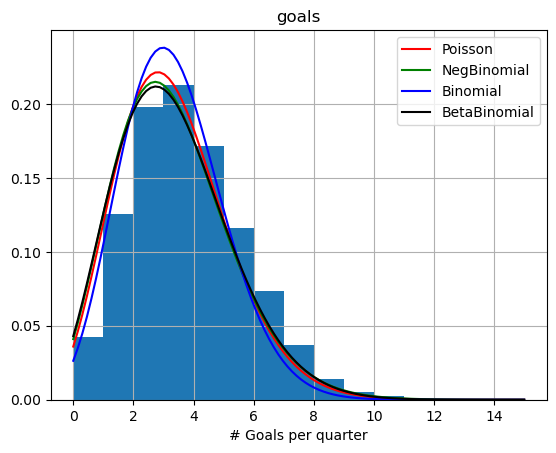

In [38]:
res = df_goals.hist("goals", bins=bins, density=True)
ax = res[0][0]
res = ax.plot(x_values, y_values_psd, 'r')
res = ax.plot(x_values, y_values_nbd, 'g')
res = ax.plot(x_values, y_values_bnd, 'b')
res = ax.plot(x_values, y_values_bbd, 'k')
plt.legend(['Poisson', 'NegBinomial', 'Binomial', 'BetaBinomial'])
plt.xlabel("# Goals per quarter")
plt.show()

We now appear to have a few reasonable options for modelling the number of goals scored in any given quarter.
However, we must not forget that the four quarterly scores form a sequence
for each team for each match. Thus, we need to check whether the four quarters are truly independent or not.
For this purpose, we now temporally aggregate the quarterly scores by summing them over each match. 

The first idea we try is to reverse the temporal dependency of match goals on quarterly goals. In such a model, the number of match goals is somehow
pre-determined in advance, and then these goals are allocated to each quarter.
Thus, we first examine the proportion of match goals allocted to each quarter.

In [50]:
match_goals = np.sum(goals_by_quarter, axis=1)
quarterly_props = (goals_by_quarter.T / match_goals).T
prop_means = np.mean(quarterly_props, axis=0)
prop_vars = np.var(quarterly_props, axis=0)
print("Proportion of match goals quarter:")
print(f"  means={prop_means}\n  variances={sigsqs}")
prop_covs = np.cov(quarterly_props.T, bias=True)
print(f"  covariances={prop_covs}")

Proportion of match goals quarter:
  means=[0.24534109 0.24738802 0.25324427 0.25402661]
  variances=[0.01521607 0.01528783 0.01525899 0.01562921]
  covariances=[[ 0.01521607 -0.00505764 -0.00465829 -0.00550014]
 [-0.00505764  0.01528783 -0.0053509  -0.00487928]
 [-0.00465829 -0.0053509   0.01525899 -0.0052498 ]
 [-0.00550014 -0.00487928 -0.0052498   0.01562921]]


It would appear that, in aggregate, the four quarters share roughly equal allocation of the match goals. However, the empirical quarterly proportions actually vary widely from match to match.
This suggests a possible model whereby the proportions are sampled from a
[Dirichlet](https://en.wikipedia.org/wiki/Dirichlet_distribution
"Wikipedia: Dirichlet distribution") distribution.
Using the method of moments, the Dirichlet parameters may be estimated from
the distributional means and variances, namely
\begin{eqnarray}
\mathbb{E}[X_i]~=~\frac{\alpha_i}{\alpha_0}~\doteq~p_i\,, & ~~\;\;~~ &
\mathbb{V}[X_i]~=~\frac{\alpha_i\,(\alpha_0-\alpha_i)}
{\alpha_0^2\,(\alpha_0+1)}~\doteq~\frac{p_i\,q_i}{\alpha_0+1}\,,
\end{eqnarray}
respectively, where $\alpha_0\doteq\sum_{i=1}^{n}\alpha_i$ and $q_i=1-p_i$.

In [66]:
alpha0s = prop_means * (1 - prop_means) / prop_vars - 1
print(f"Individual estimates of alpha_0: {alpha0s}")
alpha0 = np.sum(prop_means * (1 - prop_means)) / np.sum(prop_vars) - 1
print(f"Mean estimate of alpha0: {alpha0}")
alphas = prop_means * alpha0
print(f"Estimates of alpha_i: {alphas}")
est_covs = (np.diag(prop_means) - np.outer(prop_means, prop_means)) / (alpha0 + 1)
print(f"Estimated covariances={est_covs}")

Individual estimates of alpha_0: [11.16797652 11.17878623 11.3934525  11.1245457 ]
Mean estimate of alpha0: 11.215653723856105
Estimates of alpha_i: [2.75166069 2.77461842 2.84030008 2.84907453]
Estimated covariances=[[ 0.01515669 -0.00496858 -0.0050862  -0.00510191]
 [-0.00496858  0.01524169 -0.00512863 -0.00514448]
 [-0.0050862  -0.00512863  0.01548109 -0.00526626]
 [-0.00510191 -0.00514448 -0.00526626  0.01551264]]


An alternative model is that the quarterly proportions are fixed globally, but the numbers of goals assigned to each quarter follow a
[multinomial](https://en.wikipedia.org/wiki/Multinomial_distribution 
"Wikipedia: Multinomial dsitribution") distribution. Such a model is justified
on [theoretical](D_distributions.ipynb#Serial-correlation 
"Appendix D: Gamma-Poisson distribution: Serial correlation")
grounds if the number of goals per match follows either a Poisson or negative binomial distribution.

In [64]:
print(prop_means)
print(prop_means * (1 - prop_means) / prop_vars -  1)
print(3/16)

[0.24534109 0.24738802 0.25324427 0.25402661]
[11.16797652 11.17878623 11.3934525  11.1245457 ]
0.1875


In [53]:
quarterly_props * (1 - quarterly_props) / prop_vars - 1

array([[14.00871335, 10.76954602, 13.9664984 ,  2.54229775],
       [ 8.5509994 ,  8.50617179, 10.79178662, 14.49755264],
       [10.18109166, 13.83815094,  8.41525379, 11.33693915],
       ...,
       [15.2271536 , 13.53589231,  5.47260462,  5.31928425],
       [12.4122392 ,  7.00957331, -1.        , 14.66924564],
       [13.60443824, -1.        , 13.5633604 , 13.21838956]])

In [44]:
match_mean = np.mean(match_goals)
match_var = np.var(match_goals)
print(f"Goals per match: mean={match_mean}, variance={match_var}")
delta_var = match_var - np.sum(np.var(goals_by_quarter, axis=0))
print(f"  excess variance={delta_var}")


Goals per match: mean=13.301243481748896, variance=21.089757779866257
  excess variance=6.718457569682879
Proportion of match goals quarter:
  means=[0.24534109 0.24738802 0.25324427 0.25402661],
  variances=[0.01521607 0.01528783 0.01525899 0.01562921]


Despite the fact that a Poisson distribution is a reasonable fit to the quarterly goal scores, the number of match goals (i.e. the sum of the quarterly scores) is clearly not Poisson due to having excess variance.
This indicates that, for each team in each match, the sequence of quarterly goal scores are not independent of each other. We see further evidence of non-independence by computing the covariances and correlation coefficients between sequence scores from different quarters of the match.

In [42]:
mm = match_mean
mv = match_var
print(f"Check: p={mm / mv}, alpha={mm**2 / (mv - mm)}")

Check: p=0.6306968349559322, alpha=22.71589566235159


In [ ]:
ind = (df_training.season >= 1994) & (df_training.season != 2020)
columns  = ['for_goals' + str(i) for i in range(1, 5)]
for_scores = df_training.loc[ind, columns].values
columns  = ['against_goals' + str(i) for i in range(1, 5)]
against_scores = df_training.loc[ind, columns].values
match_goals = np.vstack([for_scores, against_scores])
match_means = np.mean(match_goals, axis=0)
match_means_sq = sum(np.outer(x, x) for x in match_goals) / match_goals.shape[0]
match_vars = match_means_sq - np.outer(match_means, match_means)
print(f"Goals per match: mean=\n{match_mean}\nvariance=\n{match_var}")
match_sum_var = np.sum(match_vars)
print(f"overall variance={match_sum_var}")
match_stds = np.sqrt(np.diag(match_vars))
match_cors = match_vars / np.outer(match_stds, match_stds)
print(f"correlations=\n{match_cors}")

In [ ]:
match_vars - np.diag(match_means)

Since the quarterly goal score distributions are assumed to be identical, we deduce that the average correlation $\rho$ between the goal scores $X_i$ of successive quarters obeys
\begin{eqnarray}
\mathbb{V}\left[\sum_{i=1}^{n}X_i\right] & = & (n+n(n-1)\rho)\,\mathbb{V}[X_1]
\end{eqnarray}

In [ ]:
n = 4
rho = (match_sum_var / quarterly_var - n) / (n * (n-1))
print(f"Goals per quarter correlation: rho={rho}")

what about binomial*beta? E[X]=n mu, V[X]=n mu (1-mu) + n(n-1) sig^2

In [ ]:
n = 20 # minutes per quarter
mu = quarterly_mean / n
sigsq = (quarterly_var - n * mu * (1 - mu)) / (n * (n-1))
print(f"mu={mu}, sigsq={sigsq}")

In [ ]:
nu = mu * (1 - mu) / sigsq - 1
alpha = mu * nu
beta = nu - alpha
print(f"alpha={alpha}, beta={beta}")


One possibility is that goal scoring is still Poisson but with a variable rate. For example, if the scoring rate were resampled before each quarter from a gamma
distribution, then the number of goals would follow a negative binomial distribution.
As a quick estimate, the method of moments gives
\begin{eqnarray}
\mu~=~\frac{\alpha\,q}{p},\,\;\;\sigma^2~=~\frac{\alpha\,q}{p^2}\,
& ~\Rightarrow~ &
p~=~\frac{\mu}{\sigma^2},\,\;\;\alpha~=~\frac{\mu\,p}{q}\,,
\end{eqnarray}
where $p$ is the probability of a failed scoring shot and $\alpha$ is the total number of failed shots, after which scoring attempts cease.

In [ ]:
p = quarterly_mean / quarterly_var
q = 1 - p
alpha = p * quarterly_mean / q
print(f"Goals per quarter: p={p}, q={q}, alpha={alpha}")

In [ ]:
p = match_mean / match_var
q = 1 - p
alpha = p * match_mean / q
print(f"Goals per match: p={p}, q={q}, alpha={alpha}")

Note that the negative binomial distribution may be derived as the sum of $\alpha$
independent, identically distributed geometric variables, each with stopping probability of $p$.

In [ ]:
y_values_psd = np.exp(psd.log_prob(x_values))

In [ ]:
from distributions.neg_binomial import NegBinomialDistribution

In [ ]:
nbd = NegBinomialDistribution()
nbd.fit(all_goals)

In [ ]:
theta, alpha = nbd.get_parameters()
print(f"p={theta}, q={1-theta}, alpha={alpha}")
mu = nbd.mean()
sigsq2 = nbd.variance()
print(f"mean={mu}, variance={sigsq2}")

We interpret $q=1-\theta\approx 0.38$ as the probability of a shot on goal actually scoring a goal, and
$p=\theta\approx 0.62$ as the probability of the shot missing or being blocked or deflected. 
Roughly speaking, shots on goal continue for the match until a total of $\alpha\approx 24$ shots fail to score. Note that, of the three distribbutions fitted, the negative binomial gives the closest match to the empirical values of both the mean and the variance.

In [ ]:
y_values_nbd = np.exp(nbd.log_prob(x_values))

In [ ]:
df_goals = pd.DataFrame({'goals': all_goals})
res = df_goals.hist(bins=20, density=True)
ax = res[0][0]
res = ax.plot(x_values, y_values_psd, 'r')
res = ax.plot(x_values, y_values_nbd, 'g')
plt.legend(['Poisson', 'NegBinomial'])
plt.xlabel("Number of goals per match")
plt.show()

### Distribution of behinds

If the ball is kicked through the goal posts without touching a goal post or a player's hand, then it scores a *goal* (worth 6 points). Otherwise, if the ball is touched or deflects off the goal post on its way through the goal posts, or else misses the goal but goes through the point posts without touching, then it scores a *behind* (worth 1 point).

In [ ]:
columns  = ['for_behinds' + str(i) for i in range(1, 5)]
for_behinds = np.sum(df_training[columns].values, axis=1, dtype=float)
columns  = ['against_behinds' + str(i) for i in range(1, 5)]
against_behinds = np.sum(df_training[columns].values, axis=1, dtype=float)

In [ ]:
# Reduce time per quarter from 25 to 20
ind = df_training.season < 1994
for_behinds[ind] *= 20 / 25
against_behinds[ind] *= 20 / 25
# Increase time per quarter from 16 to 20
ind = df_training.season == 2020
for_behinds[ind] *= 20 / 16
against_behinds[ind] *= 20 / 16

In [ ]:
all_behinds = np.concatenate([[for_behinds, against_behinds]], axis=None)
behind_mean = np.mean(all_behinds)
behind_var = np.var(all_behinds)
print(f"Behinds: mean={behind_mean}, variance={behind_var}")

In [ ]:
psd = PoissonDistribution()
psd.fit(all_behinds)

In [ ]:
lam = psd.get_parameters()[0]
print(f"lambda={lam}")
mu = psd.mean()
sigsq2 = psd.variance()
print(f"mean={mu}, variance={sigsq2}")

In [ ]:
x_values = np.linspace(min(all_behinds), max(all_behinds), 100)

In [ ]:
y_values_psd = np.exp(psd.log_prob(x_values))

In [ ]:
gd = GammaDistribution()
gd.fit(all_behinds)

In [ ]:
alpha, beta = gd.get_parameters()
print(f"alpha={alpha}, beta={beta}, theta={1/beta}")
mu = gd.mean()
sigsq2 = gd.variance()
print(f"mean={mu}, variance={sigsq2}")

In [ ]:
y_values_gd = np.exp(gd.log_prob(x_values))

In [ ]:
nbd = NegBinomialDistribution()
nbd.fit(all_behinds)

In [ ]:
theta, alpha = nbd.get_parameters()
print(f"p={theta}, q={1-theta}, alpha={alpha}")
mu = nbd.mean()
sigsq2 = nbd.variance()
print(f"mean={mu}, variance={sigsq2}")

In [ ]:
y_values_nbd = np.exp(nbd.log_prob(x_values))

In [ ]:
df_behinds = pd.DataFrame({'behinds': all_behinds})
res = df_behinds.hist(bins=20, density=True)
ax = res[0][0]
res = ax.plot(x_values, y_values_psd, 'r')
res = ax.plot(x_values, y_values_gd, 'b')
res = ax.plot(x_values, y_values_nbd, 'g')
plt.legend(['Poisson', 'Gamma', 'NegBinomial'])
plt.xlabel("Total behinds per match")
plt.show()

It would appear that the data are too variable to properly aggregate the number of behinds over each match, leading to excess granularity. Let us therefore examine the number of behinds per quarter. Also, for simplicity, we shall neglect the matches that did not have 25 minute quarters.

In [ ]:
ind = (df_training.season < 1994) & (df_training.season != 2020)
df_behinds = pd.DataFrame({'behinds': [], 'quarter': []})
for i in range(1, 5):
    behinds = np.concatenate([
        df_training.loc[ind, 'for_behinds' + str(i)].values, 
        df_training.loc[ind, 'against_behinds' + str(i)].values
    ])
    labels = str(i)
    df = pd.DataFrame({'behinds': behinds, 'quarter': labels})
    df_behinds = pd.concat([df_behinds, df], ignore_index=True)

In [ ]:
res = df_behinds.hist('behinds', by='quarter')

It appears that there might be some slight differences in scoring between quarters of a match. However, for now,
we shall adhere to the [null hypothesis](#Null-hypothesis "Section: Null hypothesis") that all quarters are essentially equal.

In [ ]:
all_behinds = df_behinds.behinds.values
behind_mean = np.mean(all_behinds)
behind_var = np.var(all_behinds)
print(f"Behinds per quarter: mean={behind_mean}, variance={behind_var}")

In [ ]:
psd = PoissonDistribution()
psd.fit(all_behinds)

In [ ]:
lam = psd.get_parameters()[0]
print(f"lambda={lam}")
mu = psd.mean()
sigsq2 = psd.variance()
print(f"mean={mu}, variance={sigsq2}")

In [ ]:
x_values = np.linspace(min(all_behinds), max(all_behinds), 100)
y_values_psd = np.exp(psd.log_prob(x_values))

Technically, the gammma distribution cannot properly model cases where zero behinds were scored in any given quarter. Hence, we try a mixture model approach.

In [ ]:
p_zero = np.sum(all_behinds == 0) / len(all_behinds)
print(f"Prob[behinds=0]={p_zero}")

In [ ]:
ind_nonzero = all_behinds > 0
nonzero_behinds = all_behinds[ind_nonzero]
gd = GammaDistribution()
gd.fit(nonzero_behinds)

In [ ]:
y_values_gd = np.zeros(len(x_values))
y_values_gd[x_values == 0] = p_zero
x_ind_nonzero = x_values > 0
y_values_gd[x_ind_nonzero] = np.exp(nbd.log_prob(x_values[x_ind_nonzero]))

In [ ]:
nbd = NegBinomialDistribution()
nbd.fit(all_behinds)

In [ ]:
theta, alpha = nbd.get_parameters()
print(f"p={theta}, q={1-theta}, alpha={alpha}")
mu = nbd.mean()
sigsq2 = nbd.variance()
print(f"mean={mu}, variance={sigsq2}")

In [ ]:
y_values_nbd = np.exp(nbd.log_prob(x_values))

In [ ]:
res = df_behinds.hist('behinds', bins=20, density=True)
ax = res[0][0]
res = ax.plot(x_values, y_values_psd, 'r')
res = ax.plot(x_values, y_values_gd, 'b')
res = ax.plot(x_values, y_values_nbd, 'g')
plt.legend(['Poisson', 'Gamma (adjusted)', 'NegBinomial'])
plt.xlabel("Number of behinds per quarter")
plt.show()

In [ ]:
np.astype

In [ ]:
x_values

## Physical representativeness

A basic assumption of probabilistic modelling is that every data point (i.e. every match) is drawn from the *same* underlying distribution. This is just the null hypothesis discussed in a
[previous](#Null-hypothesis "Section: Null hypothesis") section.
However, the outcome of each AFL match depends upon both the laws of physics and the rules of the
game. For example, there is a minimum time it takes to score from any given point of the match ground, which depends upon both player biodynamics and the dimensions of the oval (i.e. physics).
This in turn determines the maximum possible score in a fixed period of time.

However, the (nominal) length of a *quarter* depends upon the rules, which change over time.
Thus, the maximum possible score per match can also change.
Furthermore, various aspects of the game, e.g. the ability to tackle other players, also vary according to the rules. For example, the rate of scoring will be reduced when the free flow of the game is interrupted by umpires awarding penalties.

These factors raise some difficult issues. Is a given match representative of the (assumed) underlying distribution? Is one season really much like another? We shall examine some of these issues in the sections below.

### Match venue effects

Due to historical reasons, not all match grounds have the same physical dimensions.
As discussed above, this is one physical factor that determines the team scores in a match.
It might be reasoned that such physical constraints affect each team equally, and hence do not
mattter when predicting which team will win. Conversely, it might be argued that a smaller oval will give each team's defence less opportunity to restrict scoring shots by the opposition offense, and this might favour a distinctly stronger team, e.g. a team that can run faster or kick the ball further.

In order to test this effect, we examine the distribution of scores for each match venue and
see whether or not these distributions differ markedly.
Note that although the local name of each sporting ground might change over time due to naming rights from sponsorship deals, the extracted names of the venues have already been normalised.

In [ ]:
all_venues = sorted(df_training.venue.unique())
print("Found %d distinct venues" % len(all_venues))

For convenience, we ignore matches from infrequently used venues.

In [ ]:
min_num_matches = 10

In [ ]:
ds = df_training.sort_values("venue").groupby("venue").apply(len)
ind = ds >= min_num_matches  # Reject infrequent
df_sample = df_training[df_training.venue.isin(ds.index[ind])]

In [ ]:
def score_stats(df):
    scores = df[['for_total_score', 'against_total_score']].values
    n = np.size(scores)
    m = np.mean(scores)
    v = np.var(scores)
    se = np.sqrt(v / n)
    data = n, m, v, se
    index = 'size', 'mean', 'var', 'std_err'
    return pd.Series(data, index)

In [ ]:
ds_stats = score_stats(df_sample)
print(ds_stats)

In [ ]:
def group_score_stats(df, group_name):
    df_out = df.groupby(group_name).apply(score_stats)
    df_out.reset_index(drop=False, inplace=True)
    return df_out

In [ ]:
df_stats = group_score_stats(df_sample, "venue")
df_stats['sig'] = (df_stats['mean'] - ds_stats['mean']) / df_stats.std_err
print(df_stats)

Informally, we might plot the mean score of each venue along with standard error bars,
and visually check whether these are similar to the overall mean score.

In [ ]:
score_mean = ds_stats['mean']
num_groups = len(df_stats)
x = np.arange(1, num_groups + 1)
plt.plot(x, [score_mean] * num_groups, 'r')
venue_means = df_stats['mean']
plt.plot(x, venue_means, 'g')
venue_ses = df_stats.std_err
plt.plot(x, venue_means + 2 * venue_ses, 'lightgrey')
plt.plot(x, venue_means - 2 * venue_ses, 'lightgrey')
sig = (venue_means - score_mean) / venue_ses
plt.xlabel('Index of venue')
plt.ylabel('Score')
plt.legend(['overall mean', 'venue mean', '2 std. err.'])
plt.show()

This plot suggests that not all venues are like the 'average' venue.

More formally, we could perform an *analysis of variance* (ANOVA).

In [ ]:
def anova(ds_stats, df_stats):
    num_samples = int(ds_stats['size'])
    sse_total = num_samples * ds_stats['var']
    sse_within = np.dot(df_stats['size'], df_stats['var'])
    sse_between = sse_total - sse_within
    print(f"SSE: total={sse_total}, within={sse_within}, between={sse_between}")
    num_groups = len(df_stats)
    deg_total = num_samples - 1
    var_total = sse_total / deg_total
    deg_within = num_samples - num_groups
    var_within = sse_within / deg_within
    deg_between = num_groups - 1
    var_between = sse_between / deg_between
    print(f"DF: total={deg_total}, within={deg_within}, between={deg_between}")
    print(f"Var: total={var_total}, within={var_within}, between={var_between}")
    print("F-score:", var_between / var_within)

In [ ]:
anova(ds_stats, df_stats)

## Temporal representativeness